In [1]:
# @title import drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# @title Download Dataset from Kaggle (A kaggle.json should be downloaded by your Kaggle's account)
print('Upload kaggle.json account information to download the dataset:')
# files.upload()
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d mansourehk/shemo-persian-speech-emotion-detection-database
!mkdir -p ~/.shemo
!unzip -q shemo-persian-speech-emotion-detection-database.zip -d shemo
!mkdir -p ~/.data
!mv /content/shemo/female/ data
!mv /content/shemo/male/ data

Upload kaggle.json account information to download the dataset:
 98% 810M/829M [00:03<00:00, 222MB/s]
100% 829M/829M [00:03<00:00, 226MB/s]


In [3]:
# %%capture

!pip install git+https://github.com/huggingface/datasets.git
!pip install git+https://github.com/huggingface/transformers.git
# !pip install torchaudio
# !pip install librosa

# # Monitor the training process
# # !pip install wandb

# %env LC_ALL=C.UTF-8
# %env LANG=C.UTF-8
# %env TRANSFORMERS_CACHE=/content/cache
# %env HF_DATASETS_CACHE=/content/cache
# %env CUDA_LAUNCH_BLOCKING=1

# from datasets import load_dataset, load_metric

  Cloning https://github.com/huggingface/datasets.git to /tmp/pip-req-build-edblic1l
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/datasets.git /tmp/pip-req-build-edblic1l
  Resolved https://github.com/huggingface/datasets.git to commit 9fad0c69738434aec91b61d52c0450336f7535ed
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
  Created wheel for datasets: filename=datasets-2.16.2.dev0-py3-none-any.whl size=507646 sha256=3bf324576473b2d5a189871bcf96483bc9858007ec3f634b704c2decea06386a
  Stored in directory: /tmp/pip-ephem-wheel-cache-kowzkz8y/wheels/57/f4/c4/53c677af89fec0ef3226c1e75a38367b37c2fa626f0544d3e4
Successfully built datasets
  Cloning https://github.com/huggingface/transformers.git to /tmp/p

In [4]:
# @title import library
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import torchaudio
from sklearn.model_selection import train_test_split
import sys
import glob
import librosa
import IPython.display as ipd
from transformers import AutoConfig, Wav2Vec2Processor, Wav2Vec2FeatureExtractor
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
import time
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers import Wav2Vec2FeatureExtractor
import librosa

In [5]:
cuda_id = 0
device = torch.device("cuda:%s" % cuda_id if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(cuda_id) if torch.cuda.is_available() else "cpu"
print("We are using the device %s - %s" % (device, device_name))

We are using the device cuda:0 - Tesla T4


## 2. Data Processing

In [6]:
# @title load dataset
paths = []
labels = []
for dirname, _, filenames in os.walk("/content/data"):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is Loaded')

Dataset is Loaded


In [7]:
# @title Create labels
# from keras.utils import to_categorical

labels1 = [i[3] for i in np.array(labels)]

# Create a mapping between string labels and integers
label_mapping = {label: idx for idx, label in enumerate(set(labels1))}

# Convert string labels to integers using the mapping
int_labels = [label_mapping[label] for label in labels1]
num_classes = np.max(int_labels) + 1
one_hot_labels = np.eye(num_classes)[int_labels]
# one_hot_labels=one_hot_labels.reshape(3000,6)

print("String labels:", labels1)
print("Integer labels:", int_labels)
print("one_hot_labels:", list(one_hot_labels))

String labels: ['a', 'a', 'a', 'a', 'a', 'a', 'w', 's', 'h', 'a', 'n', 's', 's', 's', 'a', 's', 'n', 'a', 'n', 's', 's', 'w', 'h', 'n', 'h', 's', 'w', 'n', 'a', 'a', 'w', 'a', 'w', 'h', 'a', 's', 'a', 'n', 'n', 'n', 'h', 'w', 's', 'w', 's', 'w', 'a', 's', 'h', 'a', 'w', 's', 'n', 'a', 's', 'n', 'w', 'w', 's', 'n', 's', 'a', 'a', 'a', 's', 'n', 'n', 'n', 's', 's', 'h', 'a', 'w', 'h', 'w', 'a', 'n', 'h', 'a', 'w', 'w', 'w', 's', 's', 'a', 'h', 'a', 'a', 'a', 'h', 'a', 'a', 'f', 'h', 'a', 'w', 'n', 'a', 'a', 's', 'w', 'h', 's', 'w', 'n', 'n', 'f', 'a', 's', 's', 's', 'a', 'a', 'a', 's', 'n', 'h', 'n', 'n', 'a', 's', 's', 'a', 's', 's', 'n', 'a', 'a', 'h', 'a', 'a', 's', 'n', 'w', 'n', 'w', 'f', 'h', 'a', 'n', 'h', 'a', 'w', 'w', 'a', 'a', 's', 'a', 's', 'w', 'w', 'f', 'n', 'n', 'h', 's', 'a', 'w', 'a', 'a', 'n', 'n', 'a', 's', 'a', 's', 'a', 's', 'a', 'a', 's', 'a', 'h', 's', 'a', 'a', 'a', 'w', 'w', 'n', 'a', 'a', 'a', 'a', 'a', 'n', 'a', 'n', 'a', 'n', 'n', 's', 'n', 'a', 'a', 'a', 'a',

In [8]:
a,b=np.unique(labels1,return_counts=True)
a1,b1=np.unique(int_labels,return_counts=True)
print(a,b)
print(a1,b1)

['a' 'f' 'h' 'n' 's' 'w'] [1059   38  201 1028  449  225]
[0 1 2 3 4 5] [ 449  225 1059  201 1028   38]


In [9]:
## Create a dataframe
df = pd.DataFrame()
df['path'] = paths
df['emotion']=list(one_hot_labels)
df['emotion1']=list(int_labels)
df['emotion2']=list(labels1)
df.head()


,path,emotion,emotion1,emotion2
0,/content/data/F01A21.wav,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",2,a
1,/content/data/F24A09.wav,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",2,a
2,/content/data/F24A05.wav,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",2,a
3,/content/data/F07A01.wav,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",2,a
4,/content/data/F13A01.wav,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",2,a


In [10]:
print(len(df))

3000


In [11]:
print("Labels: ", df["emotion1"].unique())
print()
df.groupby("emotion1").count()[["path"]]

Labels:  [2 1 0 3 4 5]



,path
emotion1,
0,449
1,225
2,1059
3,201
4,1028
5,38


In [12]:
idx = np.random.randint(0, len(df))
sample = df.iloc[idx]
path = sample["path"]
label = sample["emotion"]

print(f"ID Location: {idx}")
print(f"      Label: {label}")
print()

speech, sr = torchaudio.load(path)
speech = speech[0].numpy().squeeze()
print(len(speech))
print(sr)
speech = librosa.resample(np.asarray(speech), orig_sr= sr, target_sr =16_000)
ipd.Audio(data=np.asarray(speech), autoplay=True, rate=16000)

ID Location: 1680
      Label: [0. 0. 1. 0. 0. 0.]

114506
44100


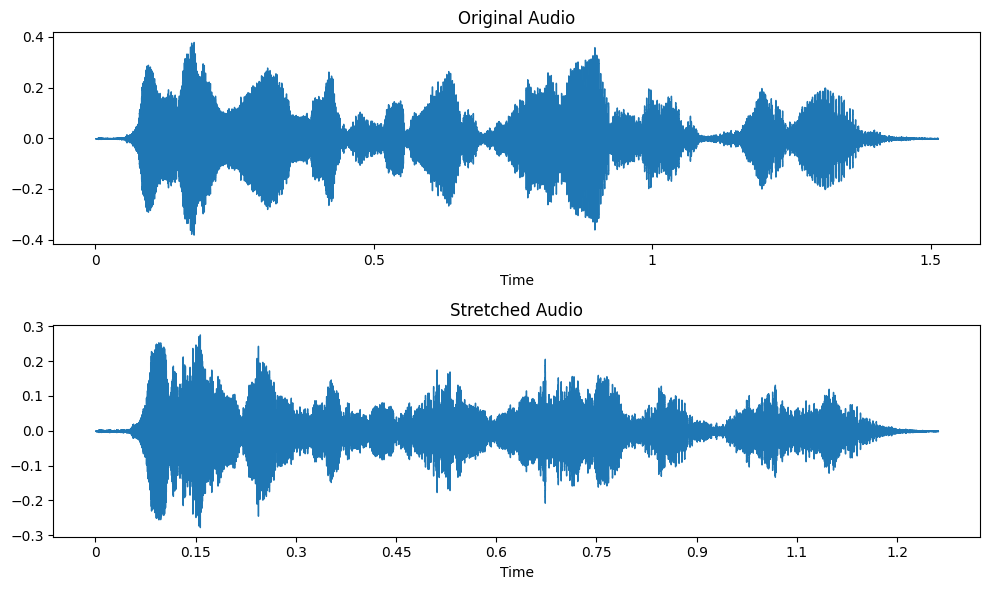

In [13]:
# @title stretched audio signals

import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load a .wav file
file_path = "/content/data/F01A01.wav"
audio, sr = librosa.load(file_path)

# Time stretching
stretched_audio = librosa.effects.time_stretch(audio, rate=1.2)

# Plot the original and stretched audio signals
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
librosa.display.waveshow(audio, sr=sr)
plt.title('Original Audio')

plt.subplot(2, 1, 2)
librosa.display.waveshow(stretched_audio, sr=sr)
plt.title('Stretched Audio')

plt.tight_layout()
plt.show()

In [14]:
ipd.Audio(data=np.asarray(audio), autoplay=True, rate=16000)

In [15]:
ipd.Audio(data=np.asarray(stretched_audio), autoplay=True, rate=16000)

In [16]:
# @title  audio + noise

import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load a .wav file
file_path = "/content/data/F01A01.wav"
audio, sr = librosa.load(file_path)

noise_level=0.004
noise = noise_level * np.random.randn(len(audio))
speech_noise = audio + noise

In [17]:
ipd.Audio(data=np.asarray(speech_noise), autoplay=True, rate=16000)

In [18]:
# @title  audio_pitch_shift

import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load a .wav file
file_path = "/content/data/F01A01.wav"
audio, sr = librosa.load(file_path)

audio_pitch_shift = librosa.effects.pitch_shift(audio, sr=sr, n_steps=1)

In [19]:
ipd.Audio(data=np.asarray(audio_pitch_shift), autoplay=True, rate=16000)

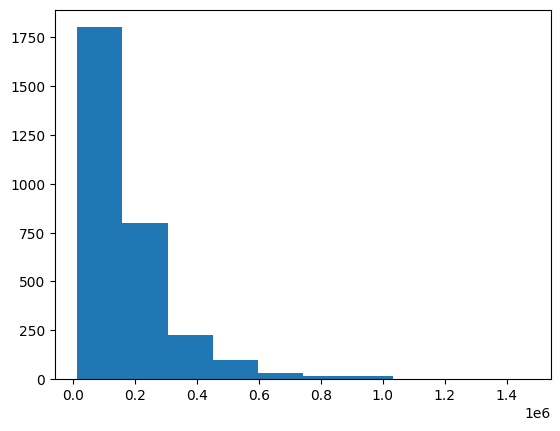

 median =  131294.5 min =  15101.0 max =  1469765.0


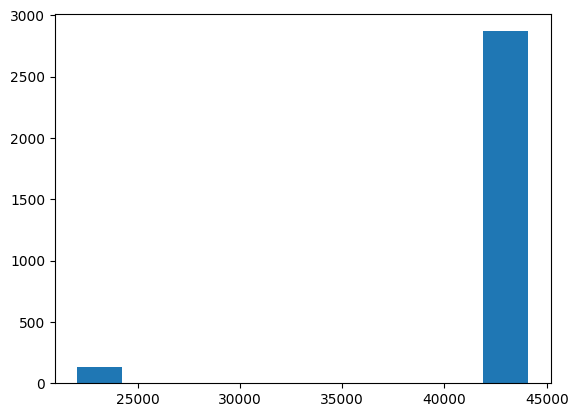

for sample rate; median =  44100.0 min =  22050.0 max =  44100.0


In [20]:
lengths_speech = np.zeros(len(df))
lengths_sr = np.zeros(len(df))
for i in range(len(df)):
  sample = df.iloc[i]
  path = sample["path"]
  speech, sr = torchaudio.load(path)
  speech = speech[0].numpy().squeeze()
  lengths_speech[i] = len(speech)
  lengths_sr[i]=sr

plt.hist(lengths_speech)
plt.show()
median = np.median(lengths_speech)
print(' median = ', median,'min = ',np.min(lengths_speech),'max = ',np.max(lengths_speech))

plt.hist(lengths_sr)
plt.show()
median = np.median(lengths_sr)
print('for sample rate; median = ', median,'min = ',np.min(lengths_sr),'max = ',np.max(lengths_sr))


In [21]:
# @title train_test_split
train_df, test_df1 = train_test_split(df, test_size=0.2, random_state=101, stratify=df["emotion1"])

val_df, test_df = train_test_split(test_df1, test_size=0.5, random_state=101, stratify=test_df1["emotion1"])

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

###  Tokenization

In [22]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
from datasets import Dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

In [23]:
def map_to_array(example):
    speech, _ = librosa.load(example["path"], sr=16000, mono=True)
    example["speech"] = speech
    return example

test_data = Dataset.from_pandas(test_df).map(map_to_array)
val_data = Dataset.from_pandas(val_df).map(map_to_array)
train_data = Dataset.from_pandas(train_df).map(map_to_array)

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

# Define a Dataset class.

In [24]:
# @title class EmotionDataset
from torch.nn.utils.rnn import pad_sequence

class EmotionDataset_train(torch.utils.data.Dataset):
    def __init__(self,data, labels,labels2,feature_extractor):
        self.data = data
        self.labels = labels
        self.labels2 = labels2
        self.feature_extractor=feature_extractor

    def __getitem__(self, idx):
      speech,sr= librosa.load(self.data["path"][idx], sr=16000, mono=True)
      if self.labels2[idx]=='f' or self.labels2[idx]=='h' or self.labels2[idx]=='s' or self.labels2[idx]=='w':
        # Probability of applying time stretching
        stretch_prob = 0.4
        noise_prob = 0.4
        Pitch_shifting_prob=0.4
        noise_level=0.004

        # Check a random value to decide whether to apply time stretching
        if np.random.rand() < stretch_prob:
          # Time stretching
          speech= librosa.effects.time_stretch(speech, rate=1.2)
        if np.random.rand() < noise_prob:
          noise = noise_level * np.random.randn(len(speech))
          speech = speech + noise
        if np.random.rand() < Pitch_shifting_prob:
            speech = librosa.effects.pitch_shift(speech, sr=sr, n_steps=1)


      encodings = self.feature_extractor(speech, sampling_rate=16000, padding=True, return_tensors="pt")

      # encodings = self.feature_extractor(speech, sampling_rate=16000,truncation=True, padding=True, max_lenght=16000)

      item = {key: val for key, val in encodings.items()}
      item['labels'] = torch.tensor(self.labels[idx])
      return item

    def __len__(self):
        return len(self.labels)


class EmotionDataset_test(torch.utils.data.Dataset):
    def __init__(self,data, labels,labels2,feature_extractor):
        self.data = data
        self.labels = labels
        self.labels2 = labels2
        self.feature_extractor=feature_extractor

    def __getitem__(self, idx):
      speech,sr= librosa.load(self.data["path"][idx], sr=16000, mono=True)
      encodings = self.feature_extractor(speech, sampling_rate=16000, padding=True, return_tensors="pt")
      item = {key: val for key, val in encodings.items()}
      item['labels'] = torch.tensor(self.labels[idx])
      return item

    def __len__(self):
        return len(self.labels)

train_dataset = EmotionDataset_train(train_df, list(train_df["emotion"]), list(train_df["emotion2"]),feature_extractor)
test_dataset = EmotionDataset_test(test_df, list(test_df["emotion"]), list(test_df["emotion2"]),feature_extractor)
val_dataset = EmotionDataset_test(val_df, list(val_df["emotion"]), list(test_df["emotion2"]),feature_extractor)


In [25]:
# print(type(test_data))
for i in range(10):
  aa=train_dataset[i]
  print("--"*100)
  print(aa)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
{'input_values': tensor([[-0.0230, -0.0385, -0.0357,  ..., -0.0711, -0.0788, -0.0595]]), 'labels': tensor([0., 0., 0., 0., 1., 0.], dtype=torch.float64)}
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
{'input_values': tensor([[ 0.0318, -0.0034,  0.0136,  ...,  0.0224,  0.0022, -0.0966]]), 'labels': tensor([0., 0., 0., 1., 0., 0.], dtype=torch.float64)}
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
{'input_values': tensor([[-0.0002, -0.0001, -0.0002,  ...,  0.0006,  0.0012, -0.0002]]), 

In [26]:
# @title DataLoader
def custom_collate_fn(batch):

    value=[torch.squeeze(batch[0]['input_values']),torch.squeeze(batch[1]['input_values'])]
    batch_labels=[torch.squeeze(batch[0]['labels']),torch.squeeze(batch[1]['labels'])]
    tensor_2d = torch.stack(batch_labels, dim=0)

    desired_length = 1469765
    # Pad sequences to the desired length
    padded_seqs = [torch.cat([seq, torch.zeros(desired_length - len(seq))]) for seq in value]
    padded_batch = pad_sequence(padded_seqs, batch_first=True, padding_value=0)


    # Pad sequences
    padded_batch = pad_sequence(value, batch_first=True, padding_value=0)
    # print(padded_batch.shape)

    return padded_batch,tensor_2d

test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=custom_collate_fn)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=False, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=custom_collate_fn)


# test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

batch = next(iter(train_loader))
print(batch)

(tensor([[-0.0230, -0.0385, -0.0357,  ..., -0.0711, -0.0788, -0.0595],
        [ 0.0035, -0.0033, -0.0122,  ...,  0.0000,  0.0000,  0.0000]]), tensor([[0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.]], dtype=torch.float64))


In [27]:

# for k,v in batch.items():
#   print(k,v.shape)

# Loading the Model and Optimizer

In [28]:
import torch.nn as nn
class hubert_classifier(nn.Module):
    def __init__(self,hidden_size,model):
        super().__init__()
        self.hidden_size = hidden_size
        self.model =model

        self.classifier = nn.Sequential(nn.Linear(hidden_size,6))

        self.softmax = nn.Softmax(-1)

    def forward(self, x):
      x1=self.model(x)
      x11=torch.mean(x1['last_hidden_state'], 1)
      x2 = self.classifier(x11)
      x3 = self.softmax(x2)
      return x3

In [29]:
from transformers import HubertModel
from torch.optim import AdamW

# Loading the model
model = HubertModel.from_pretrained("facebook/hubert-base-ls960")
model.to(device)

model_1 = hubert_classifier(768,model)
model_1 = model_1.to(device)

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model fro

## Training

In [30]:
# Loading the optimizer
optim = AdamW(model_1.classifier.parameters(), lr=1e-3)

100%|██████████| 150/150 [00:12<00:00, 11.84it/s]


EPOCH: 0
train
Mean loss: 1.4797598153352738
Mean accuracy: 0.6333333333333333
test
Mean loss: 1.4638692982991537
Mean accuracy: 0.5933333333333334

####################


100%|██████████| 150/150 [00:12<00:00, 12.22it/s]


EPOCH: 1
train
Mean loss: 1.3668364389737446
Mean accuracy: 0.7091666666666666
test
Mean loss: 1.4112924273808798
Mean accuracy: 0.6433333333333333

####################


100%|██████████| 150/150 [00:12<00:00, 12.27it/s]


EPOCH: 2
train
Mean loss: 1.338528197904428
Mean accuracy: 0.72875
test
Mean loss: 1.3966435821851095
Mean accuracy: 0.6533333333333333

####################


100%|██████████| 150/150 [00:12<00:00, 12.20it/s]


EPOCH: 3
train
Mean loss: 1.325781907737255
Mean accuracy: 0.74125
test
Mean loss: 1.3874503914515177
Mean accuracy: 0.67

####################


100%|██████████| 150/150 [00:12<00:00, 12.47it/s]


EPOCH: 4
train
Mean loss: 1.3158915763099988
Mean accuracy: 0.745
test
Mean loss: 1.3722586059570312
Mean accuracy: 0.68

####################


100%|██████████| 150/150 [00:12<00:00, 12.33it/s]


EPOCH: 5
train
Mean loss: 1.2932206629713376
Mean accuracy: 0.7708333333333334
test
Mean loss: 1.3615977454185486
Mean accuracy: 0.7

####################


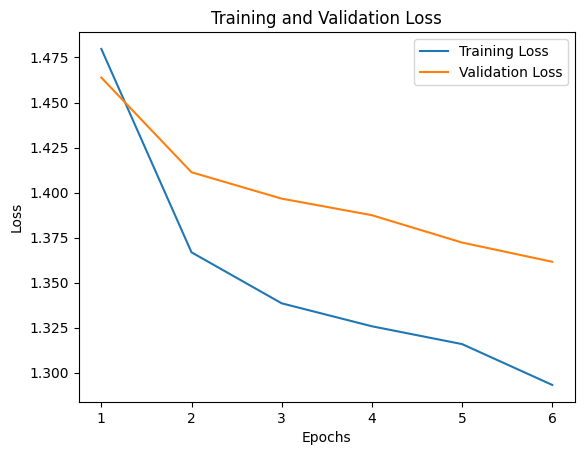

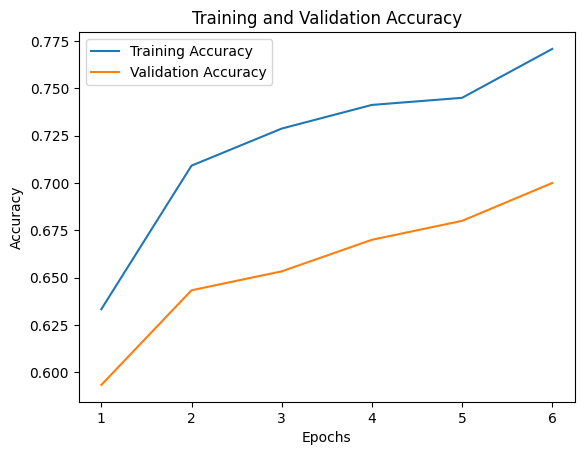

In [31]:
# Training
from sklearn.metrics import accuracy_score
from statistics import mean
import matplotlib.pyplot as plt

train_losses_plot = []
train_accuracies_plot = []
val_losses_plot = []
val_accuracies_plot = []

# Set the number of epoch
epoch = 6

# Start training
model_1.train()

criterion = nn.CrossEntropyLoss()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):

    epoch_losses_train= []
    epoch_accuracy_train=[]

    epoch_losses_val= []
    epoch_accuracy_val=[]

    for batch in tqdm(train_loader):
        optim.zero_grad()
        input_ids = batch[0].to(device)
        labels = batch[1].to(device)
        outputs = model_1(input_ids)

        loss = criterion(outputs.float(),labels.float())

        loss.backward()
        optim.step()

        new_list = [[1 if value == max(sub_list) else 0 for value in sub_list] for sub_list in outputs]
        accuracy_train=accuracy_score(new_list,labels.cpu().float().detach().numpy())
        epoch_accuracy_train.append(accuracy_train.item())
        epoch_losses_train.append(loss.item())   # record the loss for each batch

    for batch in tqdm(val_loader):
      model_1.eval()
      with torch.no_grad():
        input_ids = batch[0].to(device)
        labels = batch[1].to(device)
        outputs = model_1(input_ids)

        loss_val = criterion(outputs.float(),labels.float())

        new_list = [[1 if value == max(sub_list) else 0 for value in sub_list] for sub_list in outputs]
        accuracy_val=accuracy_score(new_list,labels.cpu().float().detach().numpy())
        epoch_accuracy_val.append(accuracy_val.item())
        epoch_losses_val.append(loss_val.item())   # record the loss for each batch

    checkpoint = {
    'epoch': epoch_i,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optim.state_dict(),
    'loss': mean(epoch_losses_val)}
    torch.save(checkpoint,"/content/drive/MyDrive/deep/hw5/" + f"model_epoch_{epoch_i}.pt")

    print(f'EPOCH: {epoch_i}')

    print("train")
    print(f'Mean loss: {mean(epoch_losses_train)}')
    print(f'Mean accuracy: {mean(epoch_accuracy_train)}')

    print("test")
    print(f'Mean loss: {mean(epoch_losses_val)}')
    print(f'Mean accuracy: {mean(epoch_accuracy_val)}')
    print()
    print("#"*20)

    train_losses_plot.append(mean(epoch_losses_train))
    train_accuracies_plot.append(mean(epoch_accuracy_train))

    val_losses_plot.append(mean(epoch_losses_val))
    val_accuracies_plot.append(mean(epoch_accuracy_val))


epochs_range = range(1, epoch + 1)

# Loss plot
plt.plot(epochs_range, train_losses_plot, label='Training Loss')
plt.plot(epochs_range, val_losses_plot, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Accuracy plot
plt.plot(epochs_range, train_accuracies_plot, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies_plot, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Testing

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_predictions = []
all_labels = []

epoch_losses_test= []
epoch_accuracy_test=[]

for batch in tqdm(test_loader):
  model_1.eval()
  with torch.no_grad():
    input_ids = batch[0].to(device)
    labels = batch[1].to(device)
    outputs = model_1(input_ids)

    loss_test = criterion(outputs.float(),labels.float())

    new_list = [[1 if value == max(sub_list) else 0 for value in sub_list] for sub_list in outputs]
    accuracy_test=accuracy_score(new_list,labels.cpu().float().detach().numpy())
    epoch_accuracy_test.append(accuracy_test.item())
    epoch_losses_test.append(loss_test.item())   # record the loss for each batch

    all_predictions.extend(new_list)
    all_labels.extend(labels.cpu().float().detach().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)


100%|██████████| 150/150 [00:11<00:00, 13.16it/s]


In [43]:
all_predictions

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0]])

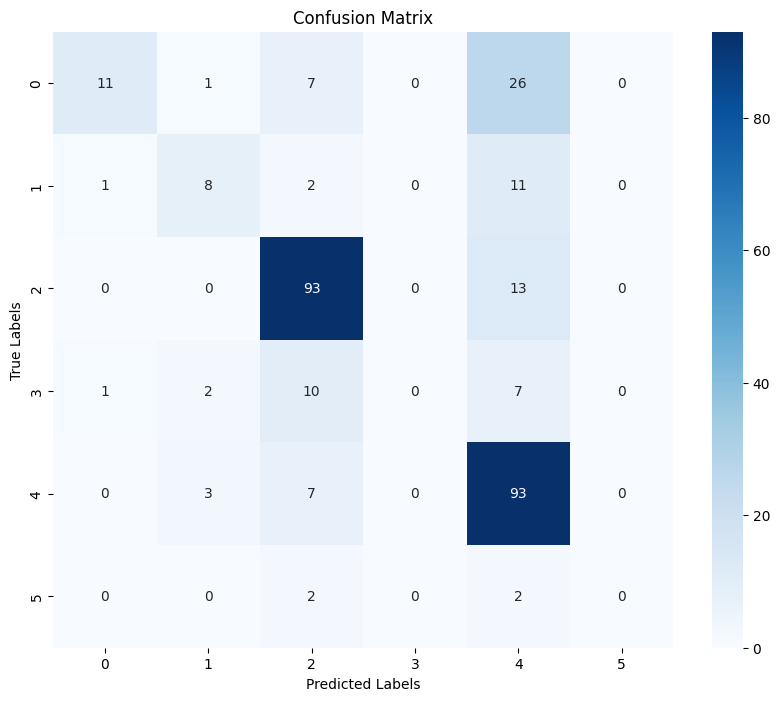

In [44]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels.argmax(axis=1), all_predictions.argmax(axis=1))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3,4,5], yticklabels=[0,1,2,3,4,5])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [45]:
from sklearn.metrics import classification_report
print(classification_report(all_labels.argmax(axis=1), all_predictions.argmax(axis=1)))


              precision    recall  f1-score   support

           0       0.85      0.24      0.38        45
           1       0.57      0.36      0.44        22
           2       0.77      0.88      0.82       106
           3       0.00      0.00      0.00        20
           4       0.61      0.90      0.73       103
           5       0.00      0.00      0.00         4

    accuracy                           0.68       300
   macro avg       0.47      0.40      0.40       300
weighted avg       0.65      0.68      0.63       300



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# delete

In [ ]:
# !rm -r /content/data/a
# !rm -r /content/data/f
# !rm -r /content/data/h
# !rm -r /content/data/n
# !rm -r /content/data/s
# !rm -r /content/data/w


In [ ]:
# for label in np.unique(labels1) :

#      os.mkdir("/content/data/"+label)

#      for p in (df[df["label"]==label])["speech"] :

#         # print(p,label)

#         os.system("cp "+p+" /content/data/"+label+"/"+os.path.basename(p))

In [ ]:
# for path in glob.glob("/content/data/*.wav") :
#   os.system("rm -r "+path)

In [ ]:
# !rm -r /content/data/male

In [ ]:
# !rm -r /content/data/female

In [ ]:
# data = []

# for path in glob.glob("/content/data/*/*.wav"):
#     name = str(path).split('/')[-1].split('.')[0]
#     label = str(path).split('/')[-2]

#     try:
#         # There are some broken files
#         s = torchaudio.load(path)
#         data.append({
#             "name": name,
#             "path": path,
#             "emotion": label
#         })
#     except Exception as e:
#         # print(str(path), e)
#         pass

#     # break

In [ ]:
# df = pd.DataFrame(data)
# df.head()

In [ ]:
# # Filter broken and non-existed paths

# print(f"Step 0: {len(df)}")

# df["status"] = df["path"].apply(lambda path: True if os.path.exists(path) else None)
# df = df.dropna(subset=["path"])
# df = df.drop("status", 1)
# print(f"Step 1: {len(df)}")

# df = df.sample(frac=1)
# df = df.reset_index(drop=True)
# df.head()